# Passing Heat Maps
Visualization and calculation of the area of dangerous passes within a set of games. This helps to show where teams began passing sequences that ultimately led to goals or shots within games.  It creates an interesting way of demonstrating where teams are able to start their attacking sequences.  In order to add context, set a window for danger passes to be those within 15 seconds of a shot.

## Imports
This version will deviate from the Soccermatics approach due to the mplsoccer library throwing an error when making a call to Statsbomb.  Instead, the statsbomb data will be called directly for the dataframe from the statsbomb library.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen, VerticalPitch
from statsbombpy import sb
import seaborn as sns

## Opening and creating the dataset
Using the sb parser in place of SBopen in mplsoccer the event data is pulled out. This effort will leverage muliple games to provide a compelling view of the teams performance.  After extracting the game numbers (mathc_id), each will be queried for the event level data. The event data is stored in a dataframe df to be evaluated in aggregate. 

In [2]:
# get matches from competition
match_ids = (sb.matches(competition_id=72, season_id=30)
            .query('home_team.str.startswith("Eng") or away_team.str.startswith("Eng")')
            .match_id
            .tolist()
           )

no_games = len(match_ids)
print(len(match_ids), match_ids)

7 [69301, 22936, 68337, 22962, 68362, 69199, 69258]


In [3]:
sb.events(69301).columns

Index(['bad_behaviour_card', 'ball_receipt_outcome',
       'ball_recovery_recovery_failure', 'block_deflection',
       'block_save_block', 'carry_end_location', 'clearance_aerial_won',
       'clearance_body_part', 'clearance_head', 'clearance_left_foot',
       'clearance_other', 'clearance_right_foot', 'counterpress',
       'dribble_outcome', 'dribble_overrun', 'duel_outcome', 'duel_type',
       'duration', 'foul_committed_advantage', 'foul_committed_card',
       'foul_committed_offensive', 'foul_committed_type', 'foul_won_advantage',
       'foul_won_defensive', 'goalkeeper_body_part', 'goalkeeper_end_location',
       'goalkeeper_outcome', 'goalkeeper_position',
       'goalkeeper_shot_saved_to_post', 'goalkeeper_technique',
       'goalkeeper_type', 'id', 'index', 'interception_outcome', 'location',
       'match_id', 'minute', 'miscontrol_aerial_won', 'off_camera', 'out',
       'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id',
       'pass_body_part', 'pass_cross', 

## Finding danger passes
For each game open the event data. Note that the use of [0] to store only event data. 
- Take out shots by England and accurate passes by England that were not set pieces. 
- Look for the passes 15 seconds before a shot. This requires iteration for/thru different periods. 

If a shot was made in 46th minute and there were 3 additional minutes in the first half include those passes. After extracting the danger passes for each game, concatenate them using a pandas dataframe. This will allow storage of danger passes across all games.

In [4]:
team = "England Women's"

#declare an empty dataframe
danger_passes = pd.DataFrame()
for idx in match_ids:
    #open the event data from this game
    df = sb.events(idx)
    for period in [1, 2]:
        #keep only accurate passes by England that were not set pieces in this period
#         mask_pass = ((df.team == team) & (df.type == "Pass") & 
#                      (df.pass_outcome.isnull()) & (df.period == period) & 
#                      (df.pass_type.isnull()))
        # create passes dataframe selecting only required columns
        passes = (df
                  .query('team==@team and type=="Pass" and pass_outcome.isnull()')
                  .query('period==@period and pass_type.isnull()')
                  .assign(x = lambda df: df.location.apply(pd.Series)[0],
                          y = lambda df: df.location.apply(pd.Series)[1],
                         xf = lambda df: df.pass_end_location.apply(pd.Series)[0],
                         yf = lambda df: df.pass_end_location.apply(pd.Series)[1])
                  [["x","y", "xf", "yf", "minute", "second", "player"]])

        #keep only Shots by England in this period
#         mask_shot = (df.team == team) & (df.type == "Shot") & (df.period == period)
        
        # create shots dataframe selecting only required columns
        shots = (df
                 .query('team==@team and type=="Shot" and period==@period')
                 .loc[:,["minute", "second"]])
        
        # create a series to filter the events based on 15sec shot window correcting for period
        shot_window = 15

        shot_start = ((shots['minute']*60+shots['second'] - shot_window)
                      .apply(lambda i: i if i>0 else (period-1)*45))
        
        #condition to avoid negative shot starts
#         shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
        
        # create pass series to filter passes to only passes in the window
        pass_to_shot = ((passes['minute']*60+passes['second'])
                     .apply(lambda x: True in ((shot_start < x) & (x < shot_start+shot_window)).unique()))
        
        #check if pass is in any of the windows for this half
#         pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

        #keep only danger passes
        danger_passes_period = passes.loc[pass_to_shot]
        
        #concatenate dataframe with a previous one to keep danger passes from the whole tournament
        danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

In [6]:
danger_passes.head()

,x,y,xf,yf,minute,second,player
0,114.6,16.4,111.3,7.1,22,40,Ellen White
1,32.9,70.0,42.0,68.5,30,26,Stephanie Houghton
2,41.7,71.0,45.1,76.5,30,27,Jill Scott
3,53.9,76.2,67.0,62.0,30,30,Nikita Parris
4,70.4,54.9,85.1,66.2,30,32,Jill Scott


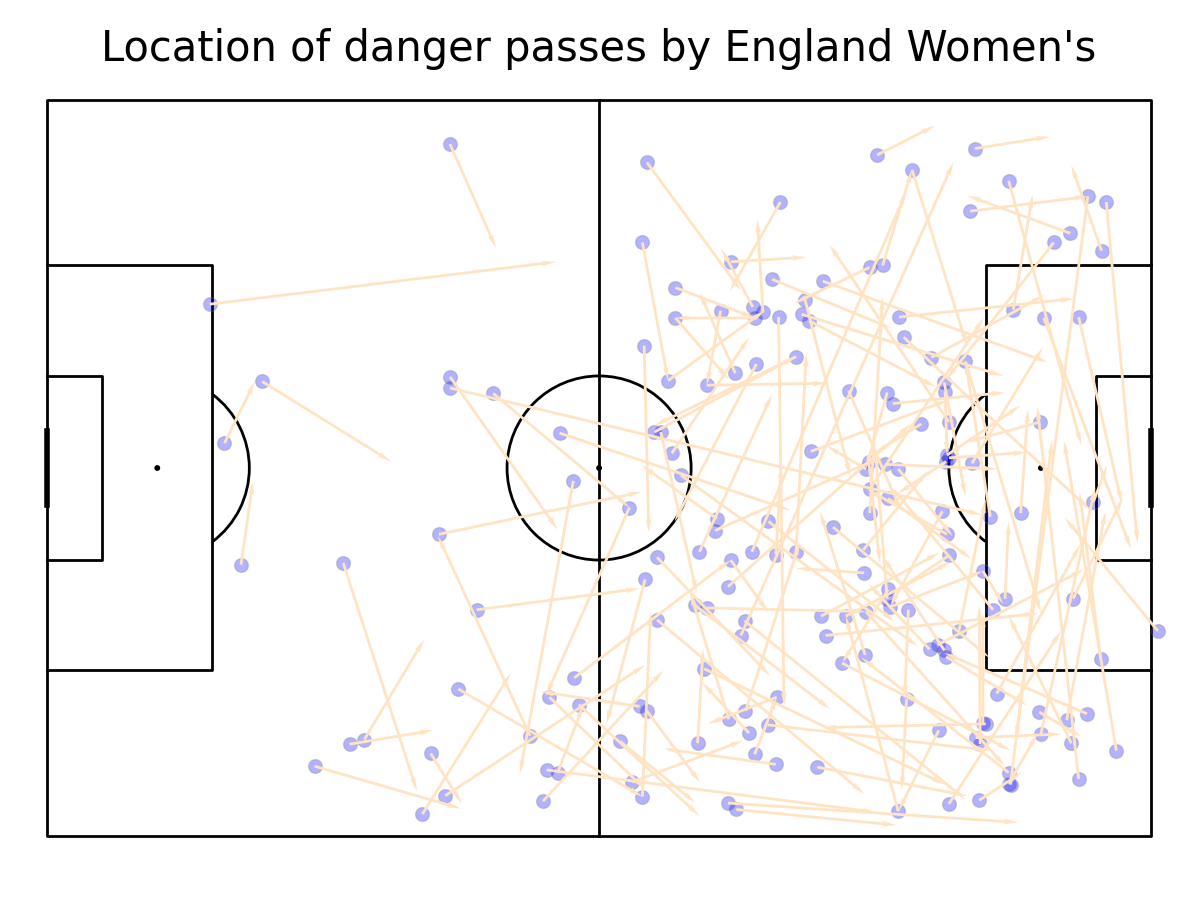

In [24]:
#plot pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', 
              edgecolors='grey', linewidth=1, alpha=0.3, ax=ax["pitch"])

#uncomment it to plot arrows
pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.xf, danger_passes.yf, 
             color = "bisque", ax=ax['pitch'], width=2, headwidth=2)

#add title
fig.suptitle('Location of danger passes by ' + team, fontsize = 30)
plt.show()

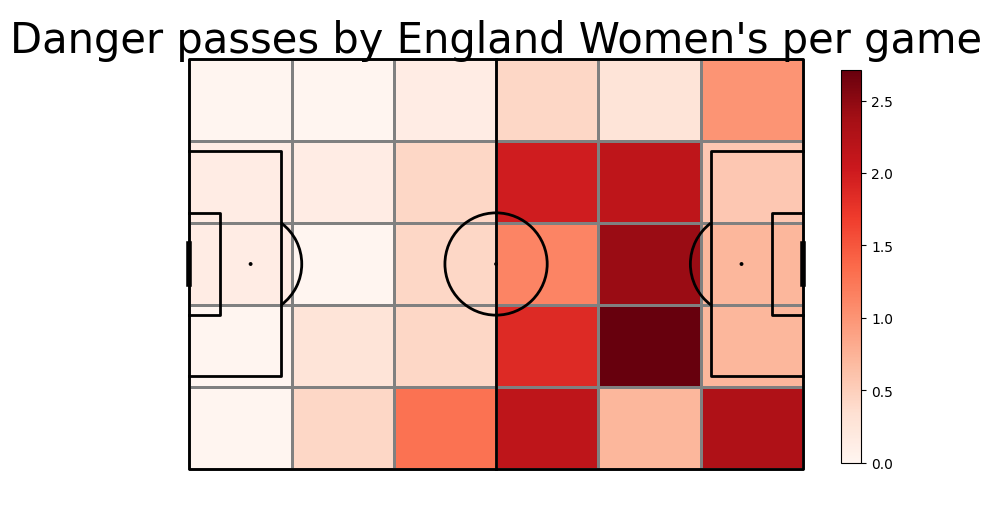

In [27]:
# plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, figheight=5,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# get the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, 
                                    statistic='count', bins=(6, 5), normalize=False)

# normalize by number of games manual
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games

#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()

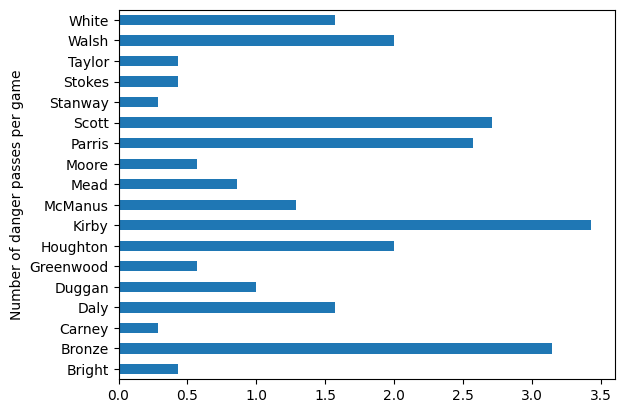

In [32]:
#keep only surnames
danger_passes["player"] = danger_passes["player"].apply(lambda x: str(x).split()[-1])

#count passes by player and normalize them
pass_count = (danger_passes.groupby(["player"]).x.count()/no_games)

#make a histogram
ax = pass_count.plot.barh(pass_count)

#make legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show()